<a href="https://colab.research.google.com/github/Edwintos/Topic-Classification-Modelling/blob/main/XLM_R_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets scikit-learn pandas matplotlib seaborn torch
!pip install imbalanced-learn

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import random
import re
from sklearn.metrics import accuracy_score
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
# AdamW is no longer imported directly but is now used through TrainingArguments
#from transformers.optimization import AdamW
from torch.nn import CrossEntropyLoss
import joblib
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Load and Inspect Your Dataset

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Define file path (Update the filename to match your uploaded CSV file)
file_path = "/content/gdrive/My Drive/Colab Notebooks/eduu.csv"  # Make sure the filename is correct

# Load dataset
df = pd.read_csv(file_path)

# Preview the dataset
print(f"Dataset shape: {df.shape}")
df.head()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset shape: (30620, 2)


,Swahili Phrase,Thematic Area
0,mvua inanyesha mingi,Nature and environment
1,leo kuna baridi,Nature and environment
2,jua itawaka kesho,Nature and environment
3,naona mvua ishaanza kunyesha,Nature and environment
4,leo kuna upepo,Nature and environment


Check for missing values and column names

In [ ]:
print("Columns:", df.columns)
print("\nMissing values:\n", df.isnull().sum())

Columns: Index(['Swahili Phrase', 'Thematic Area'], dtype='object')

Missing values:
 Swahili Phrase    1
Thematic Area     0
dtype: int64


Encode Labels and Split the Dataset

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Thematic Area'])
label_names = label_encoder.classes_
num_labels = len(label_names)

print(f"Number of classes: {num_labels}")
print("Label mapping:")
for i, label in enumerate(label_names):
    print(f"{i}: {label}")

Number of classes: 12
Label mapping:
0: Agriculture and food
1: Automotive and transport
2: Business and finance
3: Ceremony
4: Education and technology
5: Healthcare
6: History and government
7: Nature and environment
8: News and media
9: Religion and culture
10: Social setting
11: Sports and entertainment


Split the dataset (70/10/20)

In [ ]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Swahili Phrase'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.125,
    stratify=train_val_labels,
    random_state=42
)

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


Train size: 21434
Validation size: 3062
Test size: 6124


Text-Level Augmentation Functions

In [ ]:
swahili_stopwords = set(["na", "ya", "wa", "kwa", "ni", "hii", "katika", "kama", "hivyo", "au", "mara", "pia", "za", "hapo"])
swahili_synonyms = {
    "shamba": ["ardhi", "bustani"],
    "bidii": ["nguvu", "juhudi"],
    "walilima": ["walitumia", "walifanya kazi"],
    "kazi": ["juhudi", "ajira"]
}

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def synonym_replacement(words, n=1):
    new_words = words.copy()
    candidates = [w for w in words if w not in swahili_stopwords and w in swahili_synonyms]
    random.shuffle(candidates)
    for i in range(min(n, len(candidates))):
        word = candidates[i]
        synonym = random.choice(swahili_synonyms[word])
        new_words = [synonym if w == word else w for w in new_words]
    return new_words

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [word for word in words if random.uniform(0,1) > p]

def random_swap(words, n=1):
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_insertion(words, n=1):
    new_words = words.copy()
    for _ in range(n):
        word = random.choice(words)
        if word in swahili_synonyms:
            synonym = random.choice(swahili_synonyms[word])
            insert_pos = random.randint(0, len(new_words))
            new_words.insert(insert_pos, synonym)
    return new_words

def eda(text, num_aug=1):
    words = tokenize(text)
    if not words:
        return [text]
    augmented_texts = []
    for _ in range(num_aug):
        method = random.choice(["synonym", "deletion", "swap", "insertion"])
        if method == "synonym":
            aug = synonym_replacement(words, n=2)
        elif method == "deletion":
            aug = random_deletion(words, p=0.1)
        elif method == "swap":
            aug = random_swap(words, n=2)
        elif method == "insertion":
            aug = random_insertion(words, n=2)
        augmented_texts.append(" ".join(aug))
    return augmented_texts

Augment Only Minority Classes

In [ ]:
from collections import defaultdict
import random

label_to_texts = defaultdict(list)
for text, label in zip(train_texts, train_labels):
    label_to_texts[label].append(text)

max_count = max(len(texts) for texts in label_to_texts.values())

augmented_texts = []
augmented_labels = []

for label, texts in label_to_texts.items():
    current_count = len(texts)
    needed = max_count - current_count
    if needed <= 0:
        continue

    print(f"Augmenting class {label} with {needed} samples...")

    attempts = 0
    generated = 0
    max_attempts = needed * 5  # Prevent infinite loops

    while generated < needed and attempts < max_attempts:
        text = random.choice(texts)
        attempts += 1

        try:
            if not isinstance(text, str):
                text = str(text) if not pd.isna(text) else ""
            if len(text.split()) < 4:
                continue

            aug_samples = eda(text, num_aug=min(3, needed - generated))
            augmented_texts.extend(aug_samples)
            augmented_labels.extend([label] * len(aug_samples))
            generated += len(aug_samples)

        except Exception as e:
            print(f"Skipping: '{text}' | Error: {e}")


Augmenting class 9 with 8882 samples...
Augmenting class 8 with 7153 samples...
Augmenting class 11 with 9438 samples...
Augmenting class 2 with 8976 samples...
Augmenting class 1 with 8843 samples...
Augmenting class 7 with 8627 samples...
Augmenting class 6 with 8770 samples...
Augmenting class 0 with 8458 samples...
Augmenting class 4 with 7671 samples...
Augmenting class 5 with 8296 samples...
Augmenting class 3 with 9492 samples...


Add augmented samples to training set

In [ ]:
train_texts += augmented_texts
train_labels += augmented_labels

print("\n✅ Augmentation complete. New training size:", len(train_texts))



✅ Augmentation complete. New training size: 116040


Load the tokenizer

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Define a custom Dataset class

In [ ]:
class SwahiliTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze to remove the extra batch dimension
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }


Create dataset objects

In [ ]:
train_dataset = SwahiliTextDataset(train_texts, train_labels, tokenizer)
val_dataset   = SwahiliTextDataset(val_texts, val_labels, tokenizer)
test_dataset  = SwahiliTextDataset(test_texts, test_labels, tokenizer)

# Optional: create DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

Load the Pretrained Model with a Classification Head (12 labels)

In [ ]:
from transformers import XLMRobertaForSequenceClassification

# Load the pretrained XLM-R model with a classification head for 12 labels
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=12  # You are classifying into 12 thematic categories
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move Model to GPU (if available)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

Set Up the Optimizer (AdamW)

In [ ]:
from torch.optim import AdamW  # ✅ Use this instead

optimizer = AdamW(model.parameters(), lr=2e-5)


Set the Loss Function

In [ ]:
criterion = CrossEntropyLoss()

Define the Training and Evaluation Loops

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, acc, precision, recall, f1


Evaluation loop

In [ ]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics using classification_report
    report = classification_report(all_labels, all_preds, output_dict=True)

    # Extract relevant metrics
    acc = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    avg_loss = total_loss / len(dataloader)

    return avg_loss, acc, precision, recall, f1


Run Training for N Epochs

In [ ]:
num_epochs = 5  # Set the number of epochs

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}")



Epoch 1/5
Train Loss: 0.9087 | Acc: 0.7052 | Precision: 0.6984 | Recall: 0.7052 | F1: 0.6986
Val   Loss: 1.3153 | Acc: 0.5754 | Precision: 0.5003 | Recall: 0.4943 | F1: 0.4874

Epoch 2/5
Train Loss: 0.3867 | Acc: 0.8732 | Precision: 0.8718 | Recall: 0.8732 | F1: 0.8720
Val   Loss: 1.4775 | Acc: 0.5500 | Precision: 0.4845 | Recall: 0.5152 | F1: 0.4888

Epoch 3/5
Train Loss: 0.2544 | Acc: 0.9167 | Precision: 0.9162 | Recall: 0.9167 | F1: 0.9163
Val   Loss: 1.4408 | Acc: 0.5794 | Precision: 0.5086 | Recall: 0.5160 | F1: 0.5101

Epoch 4/5
Train Loss: 0.1921 | Acc: 0.9363 | Precision: 0.9361 | Recall: 0.9363 | F1: 0.9362
Val   Loss: 1.5848 | Acc: 0.5669 | Precision: 0.5023 | Recall: 0.5035 | F1: 0.4980

Epoch 5/5
Train Loss: 0.1593 | Acc: 0.9472 | Precision: 0.9470 | Recall: 0.9472 | F1: 0.9471
Val   Loss: 1.6468 | Acc: 0.5774 | Precision: 0.5020 | Recall: 0.5298 | F1: 0.5120


                          precision    recall  f1-score   support

          Social Setting       0.66      0.76      0.70       173
    Agriculture and Food       0.52      0.72      0.61       118
              Healthcare       0.42      0.59      0.49        99
    Religion and Culture       0.30      0.23      0.26        26
                Ceremony       0.51      0.46      0.49       285
    Business and Finance       0.42      0.41      0.42       196
Automotive and Transport       0.40      0.40      0.40       129
Sports and Entertainment       0.52      0.51      0.51       149
  Nature and Environment       0.49      0.46      0.48       360
Education and Technology       0.61      0.56      0.58       113
          News and Media       0.67      0.65      0.66      1381
  History and Government       0.49      0.61      0.54        33

                accuracy                           0.58      3062
               macro avg       0.50      0.53      0.51      3062
        

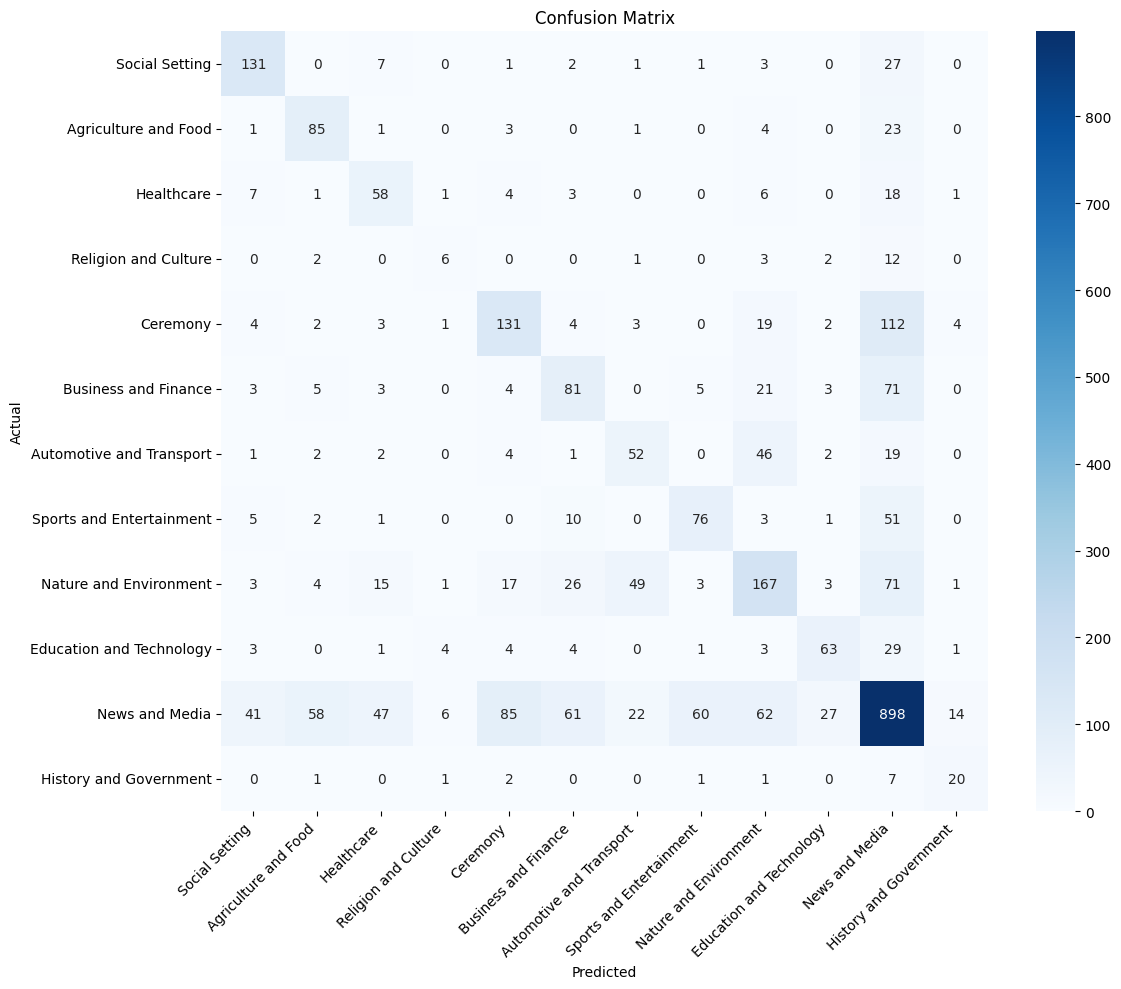

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions on the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Provide full class names matching the number of labels
class_names = [
    "Social Setting", "Agriculture and Food", "Healthcare", "Religion and Culture",
    "Ceremony", "Business and Finance", "Automotive and Transport", "Sports and Entertainment",
    "Nature and Environment", "Education and Technology", "News and Media", "History and Government"
]

# Generate report and confusion matrix
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


 Saving the Model and Tokenizer (Hugging Face format)

In [ ]:
from transformers import AutoTokenizer

# Directory to save model and tokenizer
save_directory = "swahili_topic_classifier_model"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('swahili_topic_classifier_model/tokenizer_config.json',
 'swahili_topic_classifier_model/special_tokens_map.json',
 'swahili_topic_classifier_model/sentencepiece.bpe.model',
 'swahili_topic_classifier_model/added_tokens.json')

In [ ]:
import shutil

shutil.make_archive(save_directory, 'zip', save_directory)


'/content/swahili_topic_classifier_model.zip'

In [ ]:
pip install transformers huggingface_hub

In [ ]:
from huggingface_hub import login

login()  # You’ll be prompted to enter your HF token

In [ ]:
model.push_to_hub("Edwintos/XLM-R_Base_Swahili_Topic_Classification_Model")
tokenizer.push_to_hub("Edwintos/XLM-R_Base_Swahili_Topic_Classification_Model")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Edwintos/XLM-R_Base_Swahili_Topic_Classification_Model/commit/af1b8fc4ebe1b36165bac4e8ee2812dcba1e3cdd', commit_message='Upload tokenizer', commit_description='', oid='af1b8fc4ebe1b36165bac4e8ee2812dcba1e3cdd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Edwintos/XLM-R_Base_Swahili_Topic_Classification_Model', endpoint='https://huggingface.co', repo_type='model', repo_id='Edwintos/XLM-R_Base_Swahili_Topic_Classification_Model'), pr_revision=None, pr_num=None)